# Cluster headache simulations: Full model

In [1]:
import numpy as np
from scipy.stats import lognorm, gmean, rv_discrete, norm, stats, beta, truncnorm, expon, gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Groups

We'll use stratified sampling, meaning that we will simulate subgroups of CH sufferers with common traits separately. We'll start with four groups defined by episodic vs chronic and treated vs untreated.

In [2]:
# Define the overall population
annual_prevalence = 53/100000 # 53 per 100,000 (95% CI: 26, 95) of adults
world_population = 8_200_000_000
adult_fraction = 0.72
total_ch_sufferers = world_population * adult_fraction * annual_prevalence # Estimated global CH sufferers

# Define the proportions for each group
prop_episodic = 0.80
prop_chronic = 1 - prop_episodic
prop_treated = 0.48
prop_untreated = 1 - prop_treated

# Define the groups
ch_groups = {
    'Episodic Treated': int(total_ch_sufferers * prop_episodic * prop_treated),
    'Episodic Untreated': int(total_ch_sufferers * prop_episodic * prop_untreated),
    'Chronic Treated': int(total_ch_sufferers * prop_chronic * prop_treated),
    'Chronic Untreated': int(total_ch_sufferers * prop_chronic * prop_untreated)
}

# Print group sizes
for group, size in ch_groups.items():
    print(f"{group}: {size:,.0f}")

Episodic Treated: 1,201,582
Episodic Untreated: 1,301,713
Chronic Treated: 300,395
Chronic Untreated: 325,428


## Modeling annual bout frequency for episodic CH sufferers

General idea: For ease of understanding, assume CH sufferers have an integer number of bouts per year. Combine data from papers reporting bout frequency. Use a simple discrete distribution.

In [3]:
data = {
    # Discretized approximation for a distribution with mean 1.2, SD 1.1
    'Gaul': {'n': 209, 'dist': {1: 0.6, 2: 0.3, 3: 0.1}},  
    
    # Split "<1/year" between 0 and 1, ">1/year" between 2 and 3
    'Li': {'n': 327, 'dist': {0.5: 0.416, 1: 0.370, 2.5: 0.214}},
    
    # Split "1/1.5-2 years" between 0 and 1
    'Friedman': {'n': 50, 'dist': {0.5: 0.46, 1: 0.54}},
    
    # Split "<1/year" between 0 and 1
    'Ekbom': {'n': 105, 'dist': {0.5: 0.14, 1: 0.40, 2: 0.31, 3: 0.15}},
    
    # Split "1-2/year" evenly between 1 and 2
    'Manzoni': {'n': 161, 'dist': {1: 0.27, 1.5: 0.73}},
    
    # Converted from remission periods to bouts/year, chronic cases removed
    'Sutherland': {'n': 49, 'dist': {
        0.5: 0.512+0.174,  # 1-5 years, adding >5 years for simplicity
        1: 0.140,    # 6-12 months
        2: 0.174     # 3-6 months
    }},
    
    # Estimated from remission periods, splitting some categories
    'Kudrow': {'n': 428, 'dist': {0.5: 0.19, 1: 0.67, 2.5: 0.14}}
    
}

# Combine distributions
combined_dist = {}
total_n = sum(study['n'] for study in data.values())

for study in data.values():
    weight = study['n'] / total_n
    for bouts, prob in study['dist'].items():
        combined_dist[bouts] = combined_dist.get(bouts, 0) + prob * weight

# Normalize the combined distribution
total_prob = sum(combined_dist.values())
combined_dist = {k: v/total_prob for k, v in combined_dist.items()}

# Create custom discrete distribution
bouts_per_year = rv_discrete(values=(list(combined_dist.keys()), list(combined_dist.values())))

# Function to generate annual bouts
def generate_annual_bouts():
    return bouts_per_year.rvs()

# Print statistics from distribution
mean_dist = bouts_per_year.mean()
median_dist = bouts_per_year.median()
print("Distribution statistics:")
print(f"Mean: {mean_dist:.4f}")
print(f"Median: {median_dist:.4f}")
print("Distribution:")
for value, prob in sorted(combined_dist.items()):
    print(f"Percentage {value} bouts/year: {prob*100:.1f}%")

Distribution statistics:
Mean: 1.2155
Median: 1.0000
Distribution:
Percentage 0.5 bouts/year: 21.7%
Percentage 1 bouts/year: 49.1%
Percentage 1.5 bouts/year: 8.8%
Percentage 2 bouts/year: 7.8%
Percentage 2.5 bouts/year: 9.8%
Percentage 3 bouts/year: 2.8%


## Modeling bout duration for episodic CH sufferers

General idea: Fit a lognormal distribution based on the datapoints I gathered from 8 papers.

/usr/local/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


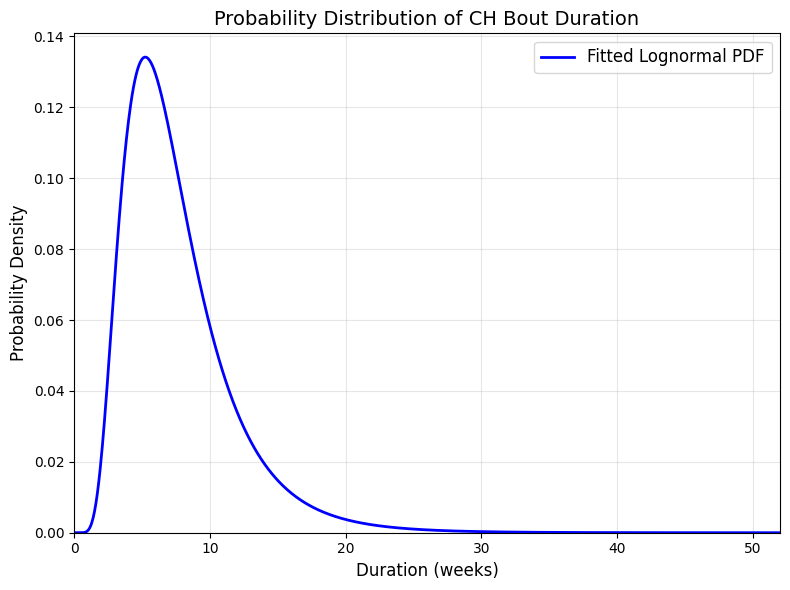

10th percentile: 3.55 weeks
25th percentile: 4.81 weeks
50th percentile: 6.74 weeks
75th percentile: 9.44 weeks
90th percentile: 12.79 weeks
99th percentile: 21.56 weeks


In [4]:
data = []
sample_sizes = []

# Gaul et al. (2012)
data.append(8.5)
sample_sizes.append(209)

# Li et al. (2022)
total_li = 327
data.extend([1, gmean([2, 4]), gmean([4, 8]), 8])
sample_sizes.extend([int(0.104 * total_li), int(0.235 * total_li), int(0.502 * total_li), int(0.131 * total_li)])

# Friedman & Mikropoulos (1958)
data.append(gmean([6, 8]))
sample_sizes.append(50)

# Ekbom (1970)
data.append(gmean([4, 12]))
sample_sizes.append(105)

# Lance & Anthony (1971)
data.append(gmean([2, 12]))
sample_sizes.append(60)

# Sutherland & Eadie (1972)
total_sutherland = 58
data.extend([gmean([0, 4]), gmean([5, 13]), gmean([14, 26]), gmean([27, 52])])
sample_sizes.extend([int(0.23 * total_sutherland), int(0.45 * total_sutherland), 
                     int(0.19 * total_sutherland), int(0.04 * total_sutherland)])

# Rozen & Fishman (2012)
data.append(10.3)
sample_sizes.append(101)

# Manzoni et al. (1983)
data.append(gmean([4, 8]))
sample_sizes.append(161)

# Convert to numpy arrays
data = np.array(data)
sample_sizes = np.array(sample_sizes)

# Use sample sizes as weights
weights = sample_sizes / np.sum(sample_sizes)

# Fitting the lognormal distribution
def neg_log_likelihood(params):
    mu, sigma = params
    return -np.sum(weights * lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))

initial_params = [np.log(np.average(data, weights=weights)), 0.5]
result = minimize(neg_log_likelihood, initial_params, method='Nelder-Mead')
optimal_mu, optimal_sigma = result.x

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 52, 1000)
plt.plot(x, lognorm.pdf(x, s=optimal_sigma, scale=np.exp(optimal_mu)), 'b-', lw=2, 
         label='Fitted Lognormal PDF')

plt.title('Probability Distribution of CH Bout Duration', fontsize=14)
plt.xlabel('Duration (weeks)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 52)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
values = lognorm.ppf(np.array(percentiles) / 100, s=optimal_sigma, scale=np.exp(optimal_mu))
for p, v in zip(percentiles, values):
    print(f"{p}th percentile: {v:.2f} weeks")

## Modeling attacks per day for both episodic and chronic CH sufferers

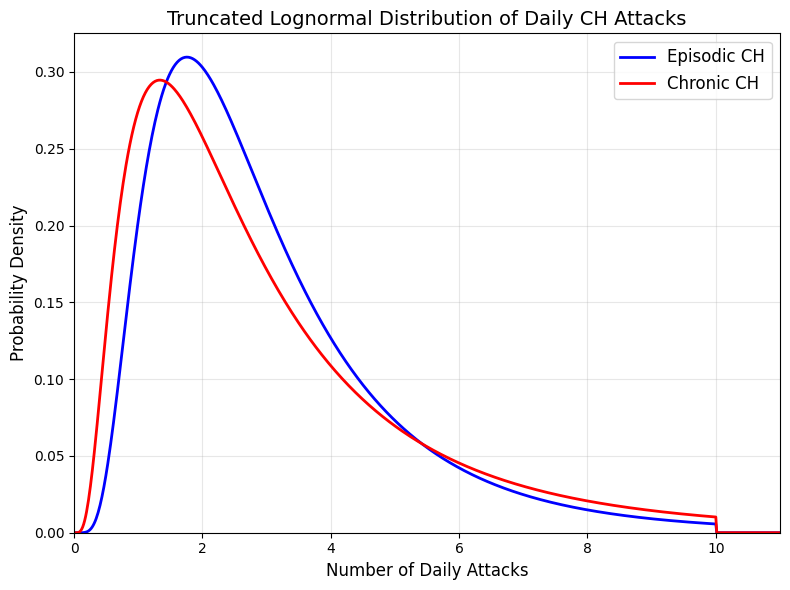


Episodic CH:
Truncated Mean: 3.10
Median: 2.57
Parameters - mu: 0.9426, sigma: 0.6146

Chronic CH:
Truncated Mean: 3.30
Median: 2.44
Parameters - mu: 0.8927, sigma: 0.7761

Episodic CH Percentiles:
10th percentile: 1.17 attacks/day
25th percentile: 1.70 attacks/day
50th percentile: 2.57 attacks/day
75th percentile: 3.88 attacks/day
90th percentile: 5.64 attacks/day
99th percentile: 10.00 attacks/day

Chronic CH Percentiles:
10th percentile: 0.90 attacks/day
25th percentile: 1.45 attacks/day
50th percentile: 2.44 attacks/day
75th percentile: 4.12 attacks/day
90th percentile: 6.60 attacks/day
99th percentile: 10.00 attacks/day


In [5]:
def fit_lognormal(mean, std):
    """
    Fit a lognormal distribution given mean and standard deviation.
    Returns the mu and sigma parameters of the lognormal distribution.
    """
    variance = std**2
    mu = np.log(mean**2 / np.sqrt(variance + mean**2))
    sigma = np.sqrt(np.log(1 + variance / mean**2))
    return mu, sigma

def truncated_lognorm_pdf(x, mu, sigma, upper_bound):
    """
    Calculate the PDF of a truncated lognormal distribution.
    """
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    cdf_upper = lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))
    return np.where(x <= upper_bound, pdf / cdf_upper, 0)

# Gaul et al. (2012) data
episodic_mean, episodic_std = 3.1, 2.1
chronic_mean, chronic_std = 3.3, 3.0
max_daily_ch = 10

# Fit lognormal distributions
episodic_mu, episodic_sigma = fit_lognormal(episodic_mean, episodic_std)
chronic_mu, chronic_sigma = fit_lognormal(chronic_mean, chronic_std)

# Function to calculate mean of truncated distribution
def truncated_mean(mu, sigma, upper_bound):
    return np.exp(mu + sigma**2/2) * (lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu)) - 
                                      lognorm.cdf(0, s=sigma, scale=np.exp(mu))) / \
           lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))

def generate_attacks_per_day(is_chronic):
    if is_chronic:
        mu, sigma = chronic_mu, chronic_sigma
    else:
        mu, sigma = episodic_mu, episodic_sigma
    
    # Generate a random number from the truncated lognormal distribution
    while True:
        attacks = lognorm.rvs(s=sigma, scale=np.exp(mu))
        if attacks <= max_daily_ch:
            break
    
    # Round to nearest integer and ensure at least 1 attack per day
    return max(1, round(attacks))

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 15, 1000)
plt.plot(x, truncated_lognorm_pdf(x, episodic_mu, episodic_sigma, max_daily_ch), 'b-', lw=2, 
         label='Episodic CH')
plt.plot(x, truncated_lognorm_pdf(x, chronic_mu, chronic_sigma, max_daily_ch), 'r-', lw=2, 
         label='Chronic CH')

plt.title('Truncated Lognormal Distribution of Daily CH Attacks', fontsize=14)
plt.xlabel('Number of Daily Attacks', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, max_daily_ch+1)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics and probabilities
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH:")
    print(f"Truncated Mean: {truncated_mean(mu, sigma, max_daily_ch):.2f}")
    print(f"Median: {lognorm.median(s=sigma, scale=np.exp(mu)):.2f}")
    print(f"Parameters - mu: {mu:.4f}, sigma: {sigma:.4f}")

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH Percentiles:")
    values = np.minimum(lognorm.ppf(np.array(percentiles) / 100, s=sigma, scale=np.exp(mu)), max_daily_ch)
    for p, v in zip(percentiles, values):
        print(f"{p}th percentile: {v:.2f} attacks/day")

## Simulating total CH annual frequency

Mean annual attacks: 249 (0.7 per day)
Median annual attacks: 166 (0.5 per day)
SD: 225
10th percentile: 53 (0.1 per day)
20th percentile: 77 (0.2 per day)
25th percentile: 88 (0.2 per day)
30th percentile: 101 (0.3 per day)
40th percentile: 129 (0.4 per day)
50th percentile: 166 (0.5 per day)
60th percentile: 219 (0.6 per day)
70th percentile: 291 (0.8 per day)
75th percentile: 333 (0.9 per day)
80th percentile: 384 (1.1 per day)
90th percentile: 574 (1.6 per day)
95th percentile: 770 (2.1 per day)
98th percentile: 946 (2.6 per day)


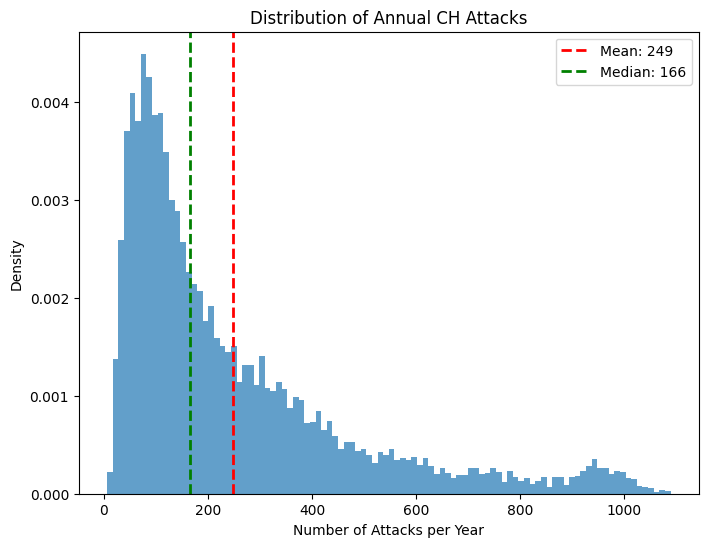

In [6]:
def generate_chronic_active_days():
    while True:
        # Generate total attack days in a year
        active_days = int(lognorm.rvs(s=.5, scale=np.exp(np.log(200))))
        
        # Ensure active_days is never over 365
        active_days = min(active_days, 365)
        
        return active_days

def simulate_annual_attacks(n_simulations=10000):
    annual_attacks = []
    
    for _ in range(n_simulations):
        # Determine if episodic or chronic
        is_episodic = np.random.random() < prop_episodic
        #is_episodic = False
        
        if is_episodic:
            # Generate number of bouts from our custom discrete distribution
            n_bouts = bouts_per_year.rvs()
            
            # Generate bout durations
            bout_durations = lognorm.rvs(s=optimal_sigma, scale=np.exp(optimal_mu), size=int(np.ceil(n_bouts)))
            
            # If n_bouts is not an integer, adjust the last bout duration
            if n_bouts != int(n_bouts):
                bout_durations[-1] *= (n_bouts - int(n_bouts))
            
            # Daily attacks for each bout
            daily_attacks = []
            for duration in bout_durations:
                days = max(1, int(duration * 7))  # Convert weeks to days, ensure at least 1 day
                attacks = np.minimum(lognorm.rvs(s=episodic_sigma, scale=np.exp(episodic_mu), size=days), max_daily_ch)
                daily_attacks.extend(np.floor(attacks))
            
            total_attacks = sum(daily_attacks)
        
        else:  # Chronic
            active_days = generate_chronic_active_days()
            daily_attacks = np.minimum(lognorm.rvs(s=chronic_sigma, scale=np.exp(chronic_mu), size=active_days), max_daily_ch)
            total_attacks = sum(np.floor(daily_attacks))
        
        annual_attacks.append(total_attacks)
    
    return np.array(annual_attacks)

# Run the simulation
annual_attack_distribution = simulate_annual_attacks()

# Calculate statistics
mean_attacks = np.mean(annual_attack_distribution)
median_attacks = np.median(annual_attack_distribution)
std_attacks = np.std(annual_attack_distribution)

percentile_values = [10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 98]
percentiles = np.percentile(annual_attack_distribution, percentile_values)

# Print results
print(f"Mean annual attacks: {mean_attacks:.0f} ({mean_attacks/365:.1f} per day)")
print(f"Median annual attacks: {median_attacks:.0f} ({median_attacks/365:.1f} per day)")
print(f"SD: {std_attacks:.0f}")
for i, percentile in enumerate(percentiles):
    print(f"{percentile_values[i]}th percentile: {percentile:.0f} ({percentile/365:.1f} per day)")

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(annual_attack_distribution, bins=100, density=True, alpha=0.7)
plt.title("Distribution of Annual CH Attacks")
plt.xlabel("Number of Attacks per Year")
plt.ylabel("Density")
plt.axvline(mean_attacks, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_attacks:.0f}')
plt.axvline(median_attacks, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_attacks:.0f}')
plt.legend()
plt.show()

### Sampling to compare with survey

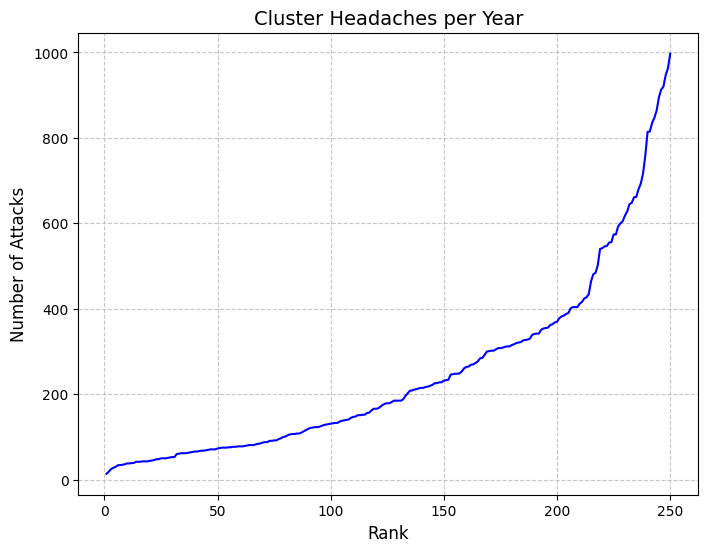

Minimum annual attacks (non-zero): 14
Maximum annual attacks: 997
Median annual attacks (non-zero): 179


In [7]:
# Sample 250 values from the distribution
sample_size = 250
sampled_attacks = np.random.choice(annual_attack_distribution, size=sample_size, replace=False)

# Sort in ascending order
sorted_attacks = np.sort(sampled_attacks)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(sorted_attacks) + 1), sorted_attacks, color='blue')
plt.title('Cluster Headaches per Year', fontsize=14)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print some statistics about the sampled data
print(f"Minimum annual attacks (non-zero): {sorted_attacks[0]:.0f}")
print(f"Maximum annual attacks: {sorted_attacks[-1]:.0f}")
print(f"Median annual attacks (non-zero): {np.median(sorted_attacks):.0f}")

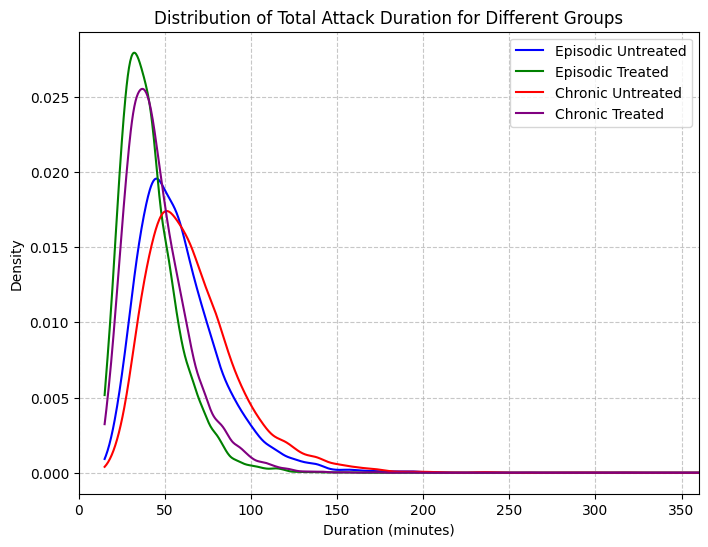


Summary for Episodic Untreated:
Mean: 58.72
Median: 54.00
Std Dev: 24.78
10th percentile: 32.00
90th percentile: 90.10

Summary for Episodic Treated:
Mean: 41.41
Median: 38.00
Std Dev: 17.00
10th percentile: 23.00
90th percentile: 64.00

Summary for Chronic Untreated:
Mean: 66.13
Median: 61.00
Std Dev: 27.41
10th percentile: 37.00
90th percentile: 101.00

Summary for Chronic Treated:
Mean: 45.73
Median: 42.00
Std Dev: 19.01
10th percentile: 25.00
90th percentile: 71.00


In [8]:
def generate_attack_duration(is_chronic, is_treated, max_intensities, size):
    # Base parameters for lognormal distribution
    mu = 4.0
    sigma = 0.4
    
    if is_chronic:
        mu += 0.1  # Slightly longer attacks for chronic sufferers
    
    # Generate base durations
    base_durations = lognorm.rvs(s=sigma, scale=np.exp(mu), size=size)
    
    # Adjust durations based on max intensities
    # This creates a positive correlation between intensity and duration
    intensity_factor = 0.1064 * max_intensities + 0.5797 # Scale factor based on intensity
    adjusted_durations = base_durations * intensity_factor
    
    if is_treated:
        treatment_effect = 0.7  # 30% reduction in duration for treated attacks
        adjusted_durations *= treatment_effect
    
    return np.clip(np.round(adjusted_durations).astype(int), 15, 360)

# Generate sample data for all four groups
n_samples = 10000
neutral_factor = (1-0.5797)/0.1064
episodic_untreated = generate_attack_duration(is_chronic=False, is_treated=False, max_intensities=neutral_factor,size=n_samples)
episodic_treated = generate_attack_duration(is_chronic=False, is_treated=True, max_intensities=neutral_factor,size=n_samples)
chronic_untreated = generate_attack_duration(is_chronic=True, is_treated=False, max_intensities=neutral_factor,size=n_samples)
chronic_treated = generate_attack_duration(is_chronic=True, is_treated=True, max_intensities=neutral_factor,size=n_samples)

# Create plot
plt.figure(figsize=(8, 6))

# Define colors for each group
colors = ['blue', 'green', 'red', 'purple']
labels = ['Episodic Untreated', 'Episodic Treated', 'Chronic Untreated', 'Chronic Treated']
datasets = [episodic_untreated, episodic_treated, chronic_untreated, chronic_treated]

# Plot KDE for each group
for data, color, label in zip(datasets, colors, labels):
    kde = gaussian_kde(data)
    x_range = np.linspace(15, 360, 1000)
    plt.plot(x_range, kde(x_range), color=color, label=label)

plt.title('Distribution of Total Attack Duration for Different Groups')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 360)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Print summary statistics for each group
for label, data in zip(labels, datasets):
    print(f"\nSummary for {label}:")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"Std Dev: {np.std(data):.2f}")
    print(f"10th percentile: {np.percentile(data, 10):.2f}")
    print(f"90th percentile: {np.percentile(data, 90):.2f}")

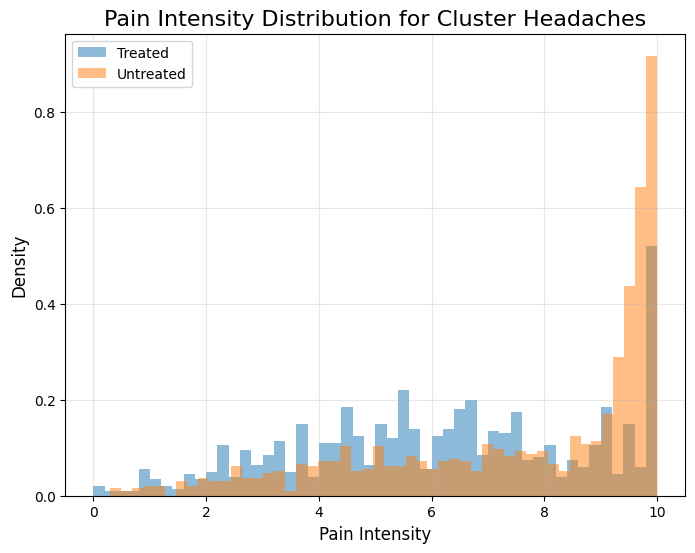


Treated:
Mean: 6.16
Median: 6.20
Percentage of 10/10 pain: 5.60%
25th percentile: 4.30
50th percentile: 6.20
75th percentile: 8.20
90th percentile: 9.80

Untreated:
Mean: 7.63
Median: 8.80
Percentage of 10/10 pain: 8.80%
25th percentile: 5.80
50th percentile: 8.80
75th percentile: 9.70
90th percentile: 9.90


In [9]:
def generate_max_pain_intensity(is_treated, size):
    
    mean_moderate = 4.0
    sd_moderate = 2.0
    mean_severe = 7.0
    sd_severe = 2.0
    #mild_to_moderate = norm.rvs(loc=4, scale=2, size=size)
    #mild_to_moderate = truncnorm.rvs(a=0, b=(7-4)/3, loc=4, scale=3, size=size)
    
    mild_to_moderate = truncnorm.rvs((0-mean_moderate)/sd_moderate, np.inf, loc=mean_moderate, scale=sd_moderate, size=size)

    #moderate_to_severe = truncnorm.rvs(a=(4-7)/3, b=(10-7)/3, loc=7, scale=3, size=size)
    moderate_to_severe = truncnorm.rvs((0-mean_severe)/sd_severe, np.inf, loc=mean_severe, scale=sd_severe, size=size)
    very_severe = 10 - expon.rvs(scale=0.4, size=size)
    
    if is_treated:
        # For treated patients:
        choices = np.random.choice(3, size=size, p=[0.40, 0.50, 0.10])
    else:
        # For untreated patients:
        choices = np.random.choice(3, size=size, p=[0.20, 0.35, 0.45])

    intensities = np.where(choices == 0, mild_to_moderate,
                  np.where(choices == 1, moderate_to_severe, very_severe))
    
    return np.round(np.clip(intensities, 0, 10), decimals=1)

# Generate samples
n_samples = 1000
treated_samples = generate_max_pain_intensity(is_treated=True, size=n_samples)
untreated_samples = generate_max_pain_intensity(is_treated=False, size=n_samples)

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(treated_samples, bins=50, alpha=0.5, label='Treated', density=True)
plt.hist(untreated_samples, bins=50, alpha=0.5, label='Untreated', density=True)
plt.title('Pain Intensity Distribution for Cluster Headaches', fontsize=16)
plt.xlabel('Pain Intensity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
for name, samples in [("Treated", treated_samples), ("Untreated", untreated_samples)]:
    print(f"\n{name}:")
    print(f"Mean: {np.mean(samples):.2f}")
    print(f"Median: {np.median(samples):.2f}")
    print(f"Percentage of 10/10 pain: {(np.array(samples) == 10).mean():.2%}")
    for p in [25, 50, 75, 90]:
        print(f"{p}th percentile: {np.percentile(samples, p):.2f}")

In [10]:
@dataclass
class Attack:
    total_duration: int
    max_intensity: float
    max_intensity_duration: int

class Patient:
    def __init__(self, is_chronic, is_treated):
        self.is_chronic = is_chronic
        self.is_treated = is_treated
        self.attacks = []
        self.generate_profile()
        self.pre_generate_attack_pool()

    def generate_profile(self):
        if self.is_chronic:
            self.active_days = generate_chronic_active_days()
        else:
            self.annual_bouts = generate_annual_bouts()
            self.bout_durations = self.generate_bout_durations()

    def pre_generate_attack_pool(self):
        # Estimate the maximum number of attacks in a year
        if self.is_chronic:
            max_attacks = self.active_days * 8  # Assuming max 8 attacks per day
        else:
            max_attacks = sum(self.bout_durations) * 8

        # Generate a pool of attacks
        max_intensities = generate_max_pain_intensity(is_treated=self.is_treated, size=max_attacks)
        total_durations = generate_attack_duration(self.is_chronic, self.is_treated, max_intensities, size=max_attacks)
        # Assuming onset and offset phases take up 15% of the total attack duration each
        max_intensity_durations = np.round(0.7 * total_durations).astype(int)

        self.attack_pool = [Attack(total_durations[i], max_intensities[i], max_intensity_durations[i])
                            for i in range(max_attacks)]
        self.pool_index = 0
        
    def generate_bout_durations(self):
        # Use the lognormal distribution for bout durations
        n_bouts = np.ceil(self.annual_bouts)
        durations = lognorm.rvs(s=optimal_sigma, scale=np.exp(optimal_mu), size=int(n_bouts))
        
        # Adjust the last bout duration if annual_bouts is not an integer
        if self.annual_bouts != int(self.annual_bouts):
            durations[-1] *= (self.annual_bouts - int(self.annual_bouts))
        
        return [max(1, int(duration * 7)) for duration in durations]  # Convert weeks to days, ensure at least 1 day

    def generate_year_of_attacks(self):
        self.attacks = []
        total_attacks = 0
        if self.is_chronic:
            for day in range(min(365, self.active_days)):
                total_attacks += self.generate_day_attacks()
        else:
            for duration in self.bout_durations:
                for day in range(duration):
                    total_attacks += self.generate_day_attacks()
        return total_attacks

    def generate_day_attacks(self):
        daily_attacks = 0
        attacks_today = generate_attacks_per_day(self.is_chronic)

        for _ in range(attacks_today):
            if self.pool_index >= len(self.attack_pool):
                # If we've used all pre-generated attacks, generate more
                self.pre_generate_attack_pool()
            
            self.attacks.append(self.attack_pool[self.pool_index])
            self.pool_index += 1
            daily_attacks += 1

        return daily_attacks

    def calculate_intensity_minutes(self):
        intensity_minutes = {}
        for attack in self.attacks:
            intensity = round(attack.max_intensity, 1)  # Round to nearest 0.1
            intensity_minutes[intensity] = intensity_minutes.get(intensity, 0) + attack.max_intensity_duration
        return intensity_minutes

Episodic Treated: N=120
Attacks - Mean: 196, Median: 148, IQR: [84, 257]
Intensity - Mean: 6.6, Median: 6.7, IQR: [4.8, 8.8]

Episodic Untreated: N=130
Attacks - Mean: 182, Median: 136, IQR: [90, 226]
Intensity - Mean: 8.1, Median: 9.2, IQR: [6.6, 9.8]

Chronic Treated: N=30
Attacks - Mean: 564, Median: 478, IQR: [344, 782]
Intensity - Mean: 6.6, Median: 6.8, IQR: [4.8, 8.8]

Chronic Untreated: N=32
Attacks - Mean: 515, Median: 474, IQR: [364, 591]
Intensity - Mean: 8.1, Median: 9.3, IQR: [6.7, 9.8]


Ratio of chronic to episodic attacks: 2.9


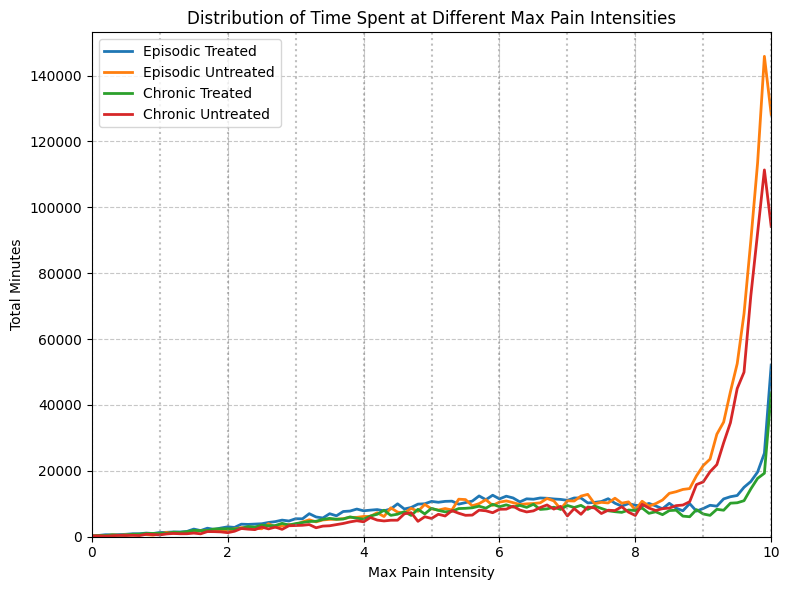

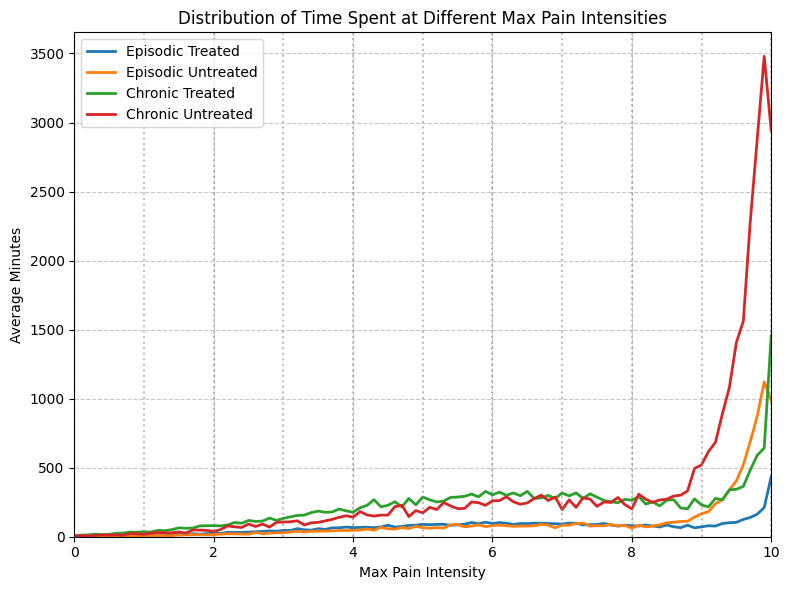

In [11]:
fraction_of_patients_to_simulate = .0001
n_episodic_treated = int(ch_groups['Episodic Treated'] * fraction_of_patients_to_simulate)
n_episodic_untreated = int(ch_groups['Episodic Untreated'] * fraction_of_patients_to_simulate)
n_chronic_treated = int(ch_groups['Chronic Treated'] * fraction_of_patients_to_simulate)
n_chronic_untreated = int(ch_groups['Chronic Untreated'] * fraction_of_patients_to_simulate)

def generate_population(n_episodic_treated, n_episodic_untreated, n_chronic_treated, n_chronic_untreated):
    population = []
    for _ in range(n_episodic_treated):
        population.append(Patient(is_chronic=False, is_treated=True))
    for _ in range(n_episodic_untreated):
        population.append(Patient(is_chronic=False, is_treated=False))
    for _ in range(n_chronic_treated):
        population.append(Patient(is_chronic=True, is_treated=True))
    for _ in range(n_chronic_untreated):
        population.append(Patient(is_chronic=True, is_treated=False))
    return population

# Generate the population
population = generate_population(n_episodic_treated, n_episodic_untreated, n_chronic_treated, n_chronic_untreated)

def calculate_group_data(population, groups_simulated):
    intensities = np.arange(0, 10.1, 0.1)
    group_data = []
    chronic_attacks = []
    episodic_attacks = []

    for group_name, condition, n_patients in groups_simulated:
        group_patients = [p for p in population if condition(p)]
        total_intensity_minutes = {}
        group_total_attacks = []
        group_intensities = []
        
        for patient in group_patients:
            total_attacks = patient.generate_year_of_attacks()
            group_total_attacks.append(total_attacks)
            
            patient_intensity_minutes = patient.calculate_intensity_minutes()
            for intensity, minutes in patient_intensity_minutes.items():
                total_intensity_minutes[intensity] = total_intensity_minutes.get(intensity, 0) + minutes
                group_intensities.extend([intensity] * int(minutes))
        
        intensity_minutes_average = [total_intensity_minutes.get(round(i, 1), 0) / n_patients for i in intensities]
        intensity_minutes_total = [total_intensity_minutes.get(round(i, 1), 0) for i in intensities]
        group_data.append((group_name, intensity_minutes_average, intensity_minutes_total, n_patients))
        
        # Calculate statistics
        attack_stats = np.percentile(group_total_attacks, [25, 50, 75])
        intensity_stats = np.percentile(group_intensities, [25, 50, 75])
        
        print(f"{group_name}: N={n_patients}")
        print(f"Attacks - Mean: {np.mean(group_total_attacks):.0f}, Median: {attack_stats[1]:.0f}, IQR: [{attack_stats[0]:.0f}, {attack_stats[2]:.0f}]")
        print(f"Intensity - Mean: {np.mean(group_intensities):.1f}, Median: {intensity_stats[1]:.1f}, IQR: [{intensity_stats[0]:.1f}, {intensity_stats[2]:.1f}]")
        print()
        
        if 'Chronic' in group_name:
            chronic_attacks.extend(group_total_attacks)
        else:
            episodic_attacks.extend(group_total_attacks)
    
    if chronic_attacks and episodic_attacks:
        ratio = np.mean(chronic_attacks) / np.mean(episodic_attacks)
        print(f"\nRatio of chronic to episodic attacks: {ratio:.1f}")
    else:
        print("\nUnable to calculate ratio due to missing data.")
    
    return intensities, group_data

def plot_data(intensities, group_data, y_label, title):
    plt.figure(figsize=(8, 6))
    for group_name, intensity_minutes, _, _ in group_data:
        plt.plot(intensities, intensity_minutes, label=group_name, linewidth=2)
    
    plt.xlabel('Max Pain Intensity')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 10)
    plt.ylim(bottom=0)
    
    for i in range(1, 11):
        plt.axvline(x=i, color='gray', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

groups_simulated = [
    ("Episodic Treated", lambda p: not p.is_chronic and p.is_treated, n_episodic_treated),
    ("Episodic Untreated", lambda p: not p.is_chronic and not p.is_treated, n_episodic_untreated),
    ("Chronic Treated", lambda p: p.is_chronic and p.is_treated, n_chronic_treated),
    ("Chronic Untreated", lambda p: p.is_chronic and not p.is_treated, n_chronic_untreated)
]

# Calculate group data and print results
intensities, group_data = calculate_group_data(population, groups_simulated)

# Plot total minutes
plot_data(intensities, [(name, total, _, _) for name, _, total, _ in group_data], 
          'Total Minutes', 'Distribution of Time Spent at Different Max Pain Intensities')

# Plot average minutes
plot_data(intensities, [(name, avg, _, _) for name, avg, _, _ in group_data], 
          'Average Minutes', 'Distribution of Time Spent at Different Max Pain Intensities')

## Additional visualization (10 patients per group)

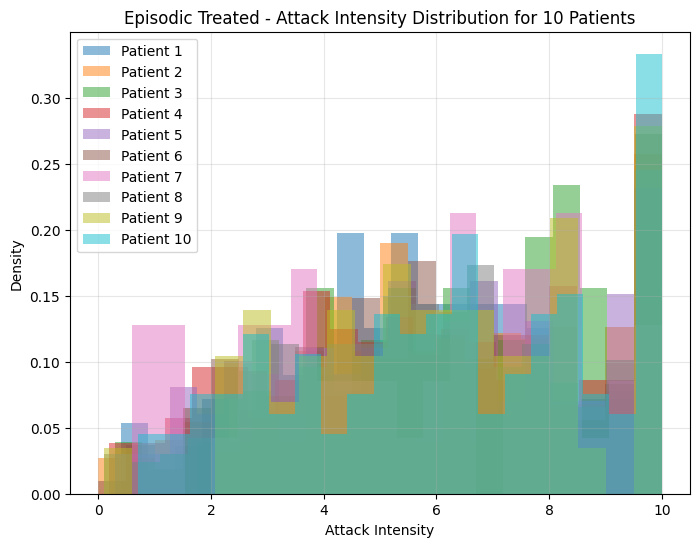

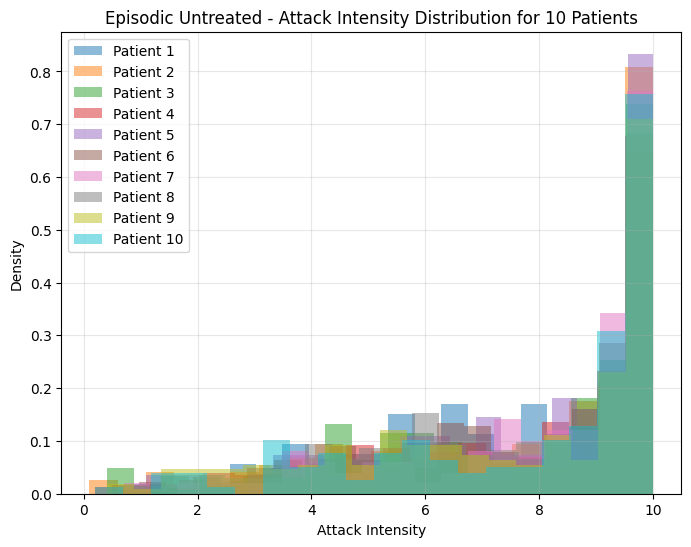

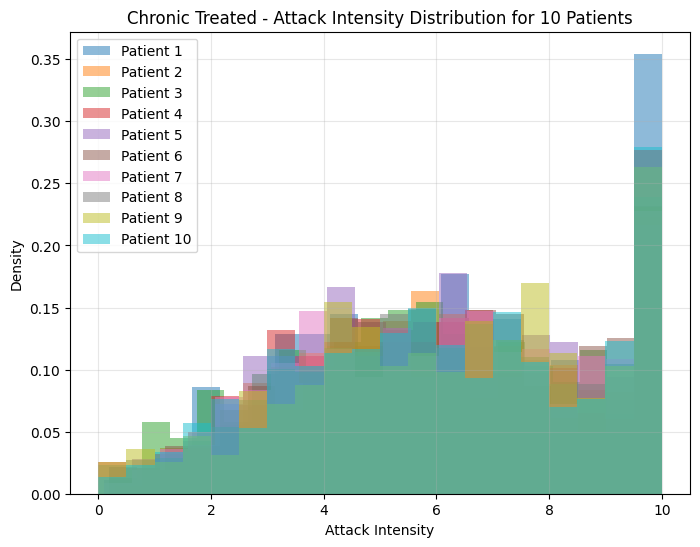

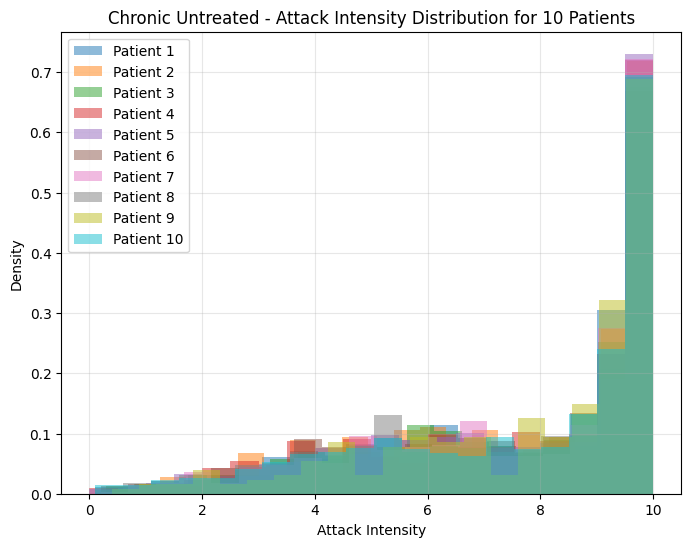

In [13]:
# Simulation function
def simulate_patients(n_patients, is_chronic, is_treated):
    patients = [Patient(is_chronic, is_treated) for _ in range(n_patients)]
    for patient in patients:
        patient.generate_year_of_attacks()
    return patients

# Generate plots
groups = [
    ("Episodic Treated", False, True),
    ("Episodic Untreated", False, False),
    ("Chronic Treated", True, True),
    ("Chronic Untreated", True, False)
]

for group_name, is_chronic, is_treated in groups:
    patients = simulate_patients(10, is_chronic, is_treated)
    
    plt.figure(figsize=(8, 6))
    for i, patient in enumerate(patients):
        intensities = [attack.max_intensity for attack in patient.attacks]
        plt.hist(intensities, bins=20, alpha=0.5, density=True, label=f'Patient {i+1}')
    
    plt.title(f'{group_name} - Attack Intensity Distribution for 10 Patients')
    plt.xlabel('Attack Intensity')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()